In [1]:
import numpy as np
import scipy.stats as stats
import nibabel.freesurfer.mghformat as mgh
import h5py

import sys

sys.path.append("..")

from paths import *
from constants import *

sys.path.append(CODE_PATH)

from utils.general_utils import make_iterable

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors as mcolors

In [3]:
def reject_outliers(data, m=2):
    d = np.abs(data - np.mean(data))
    mdev = np.mean(d)
    s = d / (mdev if mdev else 1.)
    return data[s < m]

In [4]:
subjid = ["01", "02", "03", "04", "05", "06", "07", "08"]
roi = "streams_shrink10"
hemis = [ "lh", "rh"]
mapping_func = "Ridge" #"PLS"
CV = 1# 0
subsample = 2
FULL_ROI_NAMES = ['Early',
             'Midventral',
             'Midlateral',
             'Midparietal',
             'Ventral',
             'Lateral',
             'Parietal']
ROI_NAMES = ['Ventral',
             'Lateral',
             'Parietal']
models = [ "untrained_alexnet", "alexnet_torch", "vgg16", "cornet-s", "resnet18", "resnet50", "resnet101"]

source_roi = "streams_shrink10"
num_splits = 10
n_source_voxels = 10000 #15000

In [5]:
means_s2s = np.empty((len(subjid), len(ROI_NAMES)))
all_s2s_rs = [[[] for j in range(len(ROI_NAMES))] for i in range(len(subjid))]

means = np.empty((len(subjid), len(ROI_NAMES), len(models)))
all_rs = [[[[] for m in range(len(models)+2)] for j in range(len(ROI_NAMES))] for i in range(len(subjid))]

num_vox = np.zeros((len(hemis)))

ventral2lateral = {}
ventral2parietal = {}
lateral2ventral = {}
lateral2parietal = {}
parietal2ventral = {}
parietal2lateral = {}

for sidx, sid in enumerate(subjid):
    
    temp_s2s = {}
    
    for hidx, hemi in enumerate(hemis):
        # Get ROI data
        mgh_file = mgh.load(
            NSDDATA_PATH
            + "freesurfer/subj"
            + sid
            + "/label/"
            + hemi
            + "."
            + roi
            + ".mgz"
        )
        streams = mgh_file.get_fdata()[:, 0, 0]
        num_vox[hidx] = streams[streams != 0].shape[0]
        if hidx > 0:
            streams_trim = np.append(streams_trim, streams[streams != 0])
        else:
            streams_trim = streams[streams != 0]

        # Get subject 2 subject mapping estimates
        load_path = (RESULTS_PATH
                    + "fits/subj2subj/subj"
                    + sid
                    + "_"
                    + hemi
                    + "_"
                    + source_roi
                    + "_to_"
                    + roi
                    + "_"
                    + mapping_func
                    + "_1CV_"
                    + str(num_splits)
                    + "splits_"
                    + "_subsample_"
                    + str(n_source_voxels if n_source_voxels is not None else 0)
                    + "voxels_subsamptype1_pooled1.hdf5") #_subsamptype1.hdf5")
        #load_path = (RESULTS_PATH
        #            + "fits/subj2subj/subj"
        #            + sid
        #            + "_"
        #            + hemi
        #            + "_"
        #            + source_roi
        #            + "_to_"
        #            + roi
        #            + "_"
        #            + str(num_splits)
        #            + "splits_"
        #            + "_subsample_"
        #            + str(n_source_voxels if n_source_voxels is not None else 0)
        #            + "voxels_subsamptype1.hdf5")
        rsquared_array = {}
        with h5py.File(load_path, "r") as f:
            keys = f.keys()
            for k in keys:
                rsquared_array[k] = f[k][:]
        
        for r, layer in enumerate(ROI_NAMES):        
            if hidx > 0:
                temp_s2s[layer] = np.append(temp_s2s[layer], rsquared_array[layer])
            else:
                temp_s2s[layer] = rsquared_array[layer]
    
    for r, layer in enumerate(ROI_NAMES):
        all_s2s_rs[sidx][r] = temp_s2s[layer][streams_trim==r+5]
        
    lateral2ventral[sidx] = temp_s2s["Lateral"][streams_trim==5]
    parietal2ventral[sidx] = temp_s2s["Parietal"][streams_trim==5]
    
    ventral2lateral[sidx] = temp_s2s["Ventral"][streams_trim==6]
    parietal2lateral[sidx] = temp_s2s["Parietal"][streams_trim==6]
    
    lateral2parietal[sidx] = temp_s2s["Lateral"][streams_trim==7]
    ventral2parietal[sidx] = temp_s2s["Ventral"][streams_trim==7]
    
    for midx, model_name in enumerate(models):
        
        if model_name == "untrained_alexnet":
            model_name = "alexnet_torch"
            pretrained = False
        else:
            pretrained = True
            
        for hidx, hemi in enumerate(hemis):
            # get model fits
            load_path = (RESULTS_PATH
                        + "fits/"
                        +("by_layer_" if model_name == "slowfast_full1" else "")
                        +"subj"
                        + sid
                        + "_"
                        + hemi
                        + "_"
                        + roi
                        + "_"
                        + model_name
                        + "_"
                        + mapping_func
                        + "_subsample_"
                        + str(subsample)
                        + "_"
                        + str(CV)
                        + "CV_"
                        + ("0pretraining_" if pretrained is False else "1pretraining_")
                        #+ ("0pretraining_" if pretrained is False else "")
                        #+ ("1pretraining_" if model_name == "slowfast_full1" else "")
                        + "fits"
                        + ".hdf5")
            fits = {}
            with h5py.File(load_path, "r") as f:
                keys = f.keys()
                for k in keys:
                    fits[k] = f[k][:]

            if model_name == "alexnet":
                layer_keys = ALEXNET_LAYERS
            elif model_name == "alexnet_torch":
                layer_keys = ALEXNET_TORCH_LAYERS
            elif model_name == "vgg16":
                layer_keys = VGG16_LAYERS
            elif model_name == "resnet18":
                layer_keys = RESNET18_LAYERS
            elif model_name == "resnet50":
                layer_keys = RESNET50_LAYERS
            elif model_name == "resnet101":
                layer_keys = RESNET101_LAYERS
            elif model_name == "cornet-s":
                layer_keys = CORNETS_LAYERS
            elif model_name == "slowfast_full1":
                    layer_keys = MATCHING_SLOWFAST_LAYERS
            layer_keys = [
                item
                for sublist in [
                    [item] if type(item) is not list else item for item in layer_keys
                ]
                for item in sublist
            ]

            rs_by_layer = np.zeros((len(layer_keys), int(num_vox[hidx])))
            for lix, layer in enumerate(layer_keys):
                rs_by_layer[lix,:] = fits[layer] #reshape dict to array
            
            if hidx > 0:
                max_rs = np.append(max_rs, np.amax(rs_by_layer, axis=0))
            else:
                max_rs = np.amax(rs_by_layer, axis=0)
            
        for r in range(len(ROI_NAMES)):
            all_rs[sidx][r][midx] = max_rs[streams_trim==r+5]
            means[sidx, r, midx] =  np.mean(max_rs[streams_trim==r+5])

In [6]:
len(all_s2s_rs[0])

3

In [7]:
print(np.mean(all_s2s_rs[0][0]))
print(np.mean(all_s2s_rs[0][1]))
print(np.mean(all_s2s_rs[0][2]))

print(np.mean(all_s2s_rs[1][0]))
print(np.mean(all_s2s_rs[1][1]))
print(np.mean(all_s2s_rs[1][2]))

print(np.mean(all_s2s_rs[2][0]))
print(np.mean(all_s2s_rs[2][1]))
print(np.mean(all_s2s_rs[2][2]))

print(np.mean(all_s2s_rs[3][0]))
print(np.mean(all_s2s_rs[3][1]))
print(np.mean(all_s2s_rs[3][2]))

print(np.mean(all_s2s_rs[4][0]))
print(np.mean(all_s2s_rs[4][1]))
print(np.mean(all_s2s_rs[4][2]))

0.2780112176054198
0.32605650172002354
0.2434881149120922
0.3229499745489286
0.32522417225163014
0.2230556731297838
0.28205275990997897
0.3221800543091928
0.22392316737815154
0.3112939293314783
0.3647883079845271
0.256284071826088
0.38215156001419825
0.3504499936251106
0.3190950968012959


In [8]:
for sidx, sid in enumerate(subjid):
    for r in range(len(ROI_NAMES)):
        if r == 0: # Ventral
            all_rs[sidx][r][-2] = lateral2ventral[sidx] 
            all_rs[sidx][r][-1] = parietal2ventral[sidx] 
        elif r == 1: # Lateral 
            all_rs[sidx][r][-2] = ventral2lateral[sidx] 
            all_rs[sidx][r][-1] = parietal2lateral[sidx] 
        elif r == 2: # Lateral 
            all_rs[sidx][r][-2] = ventral2parietal[sidx] 
            all_rs[sidx][r][-1] = lateral2parietal[sidx] 
        

01


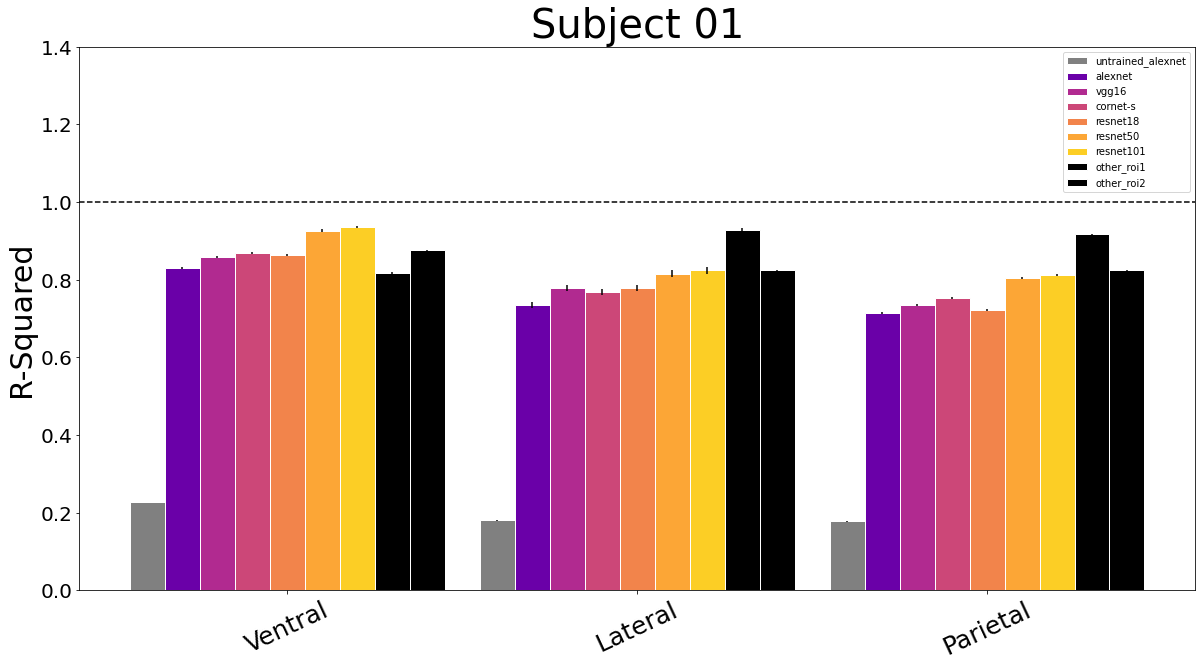

02


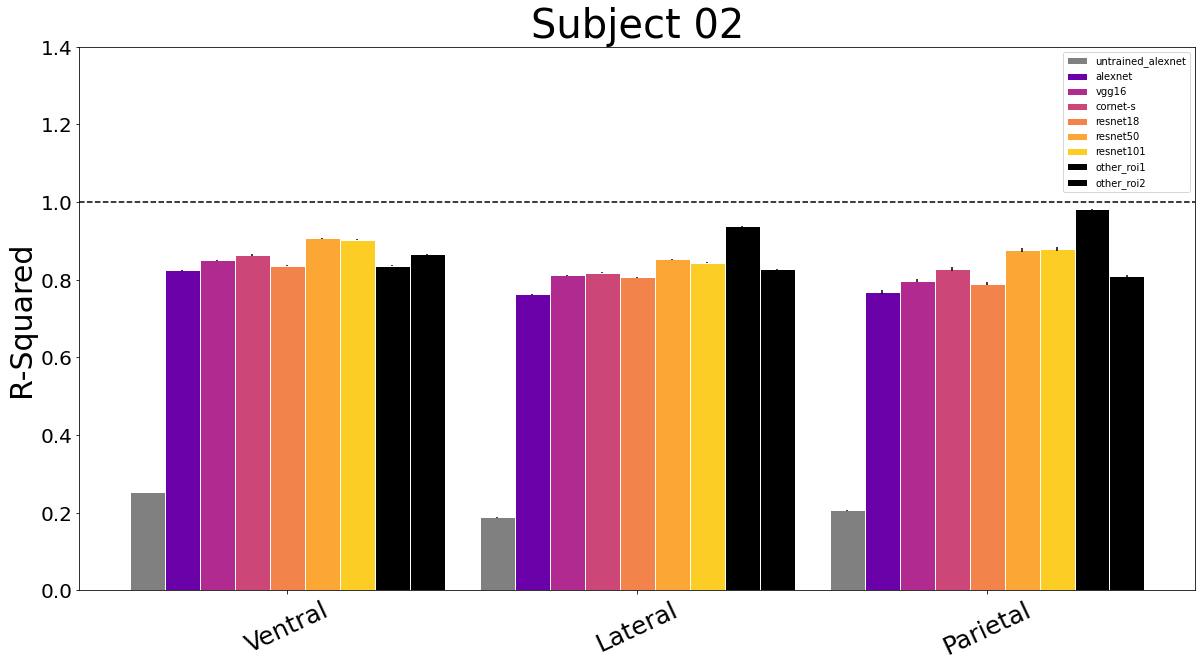

03


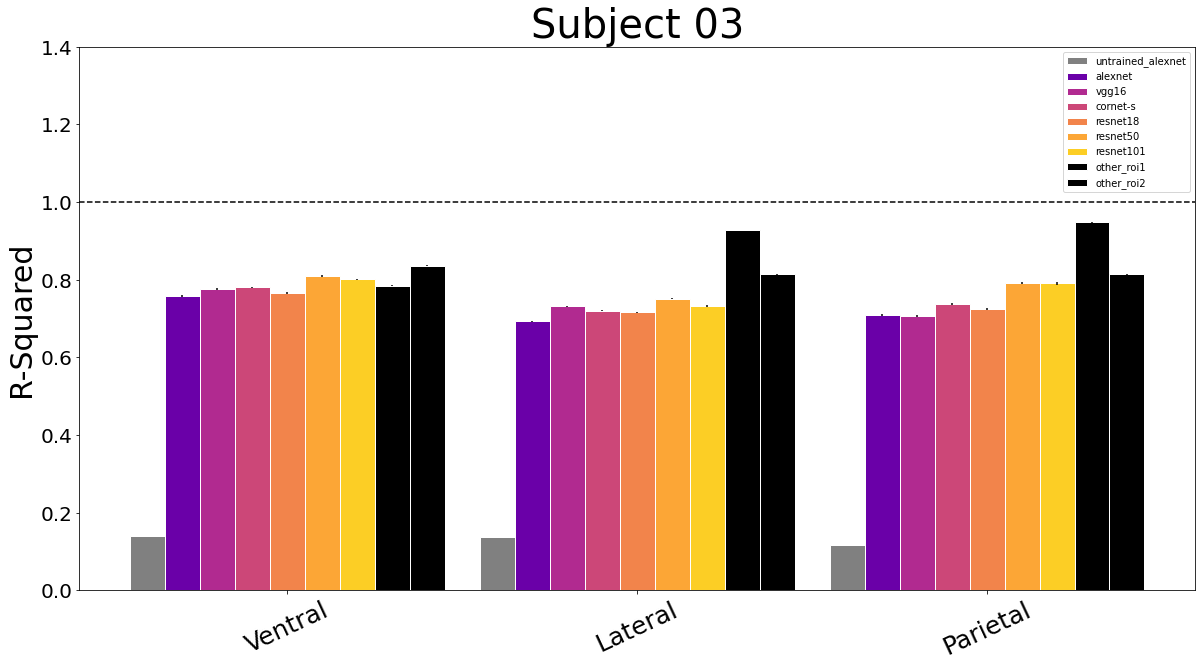

04


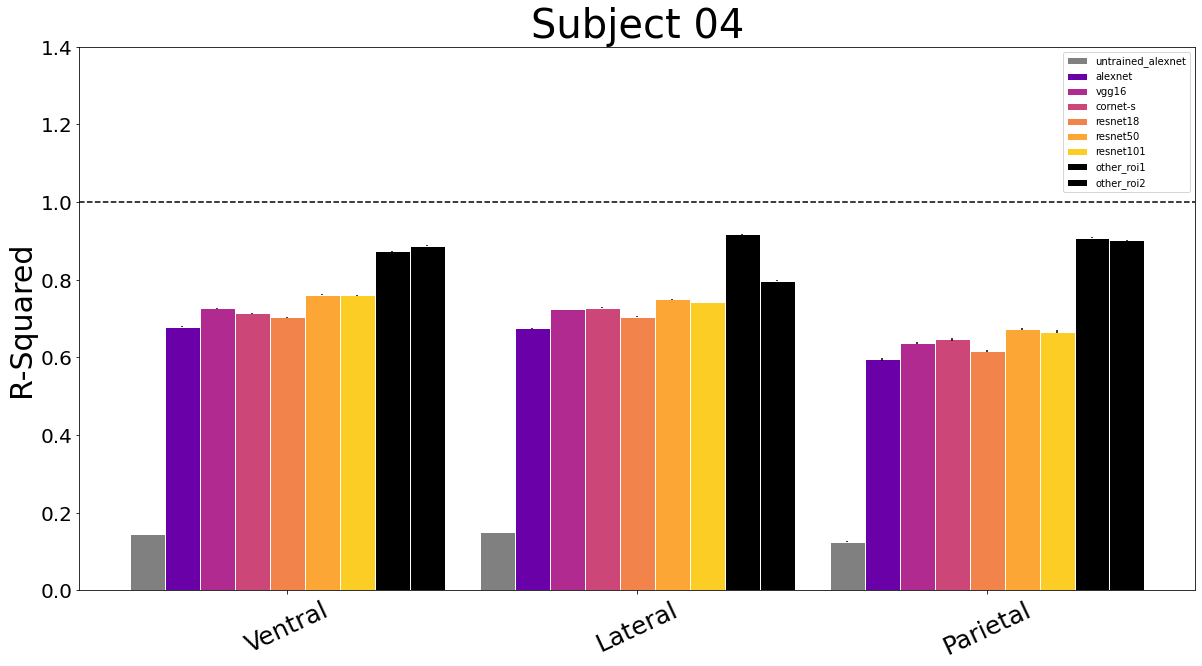

05


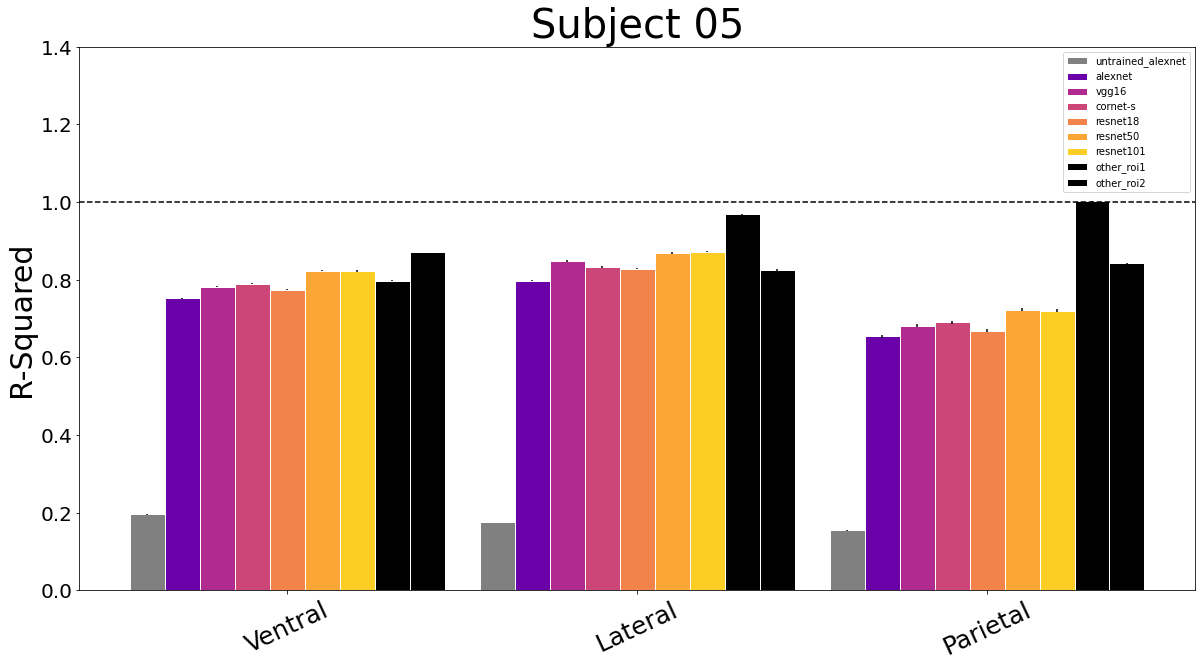

06


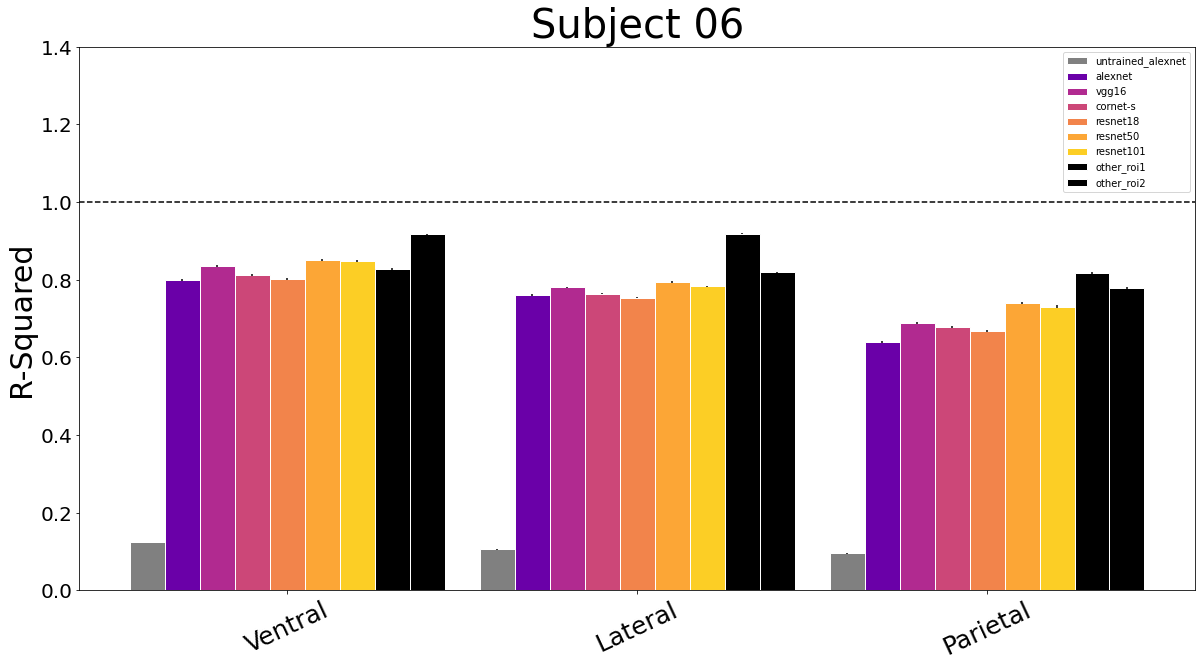

07


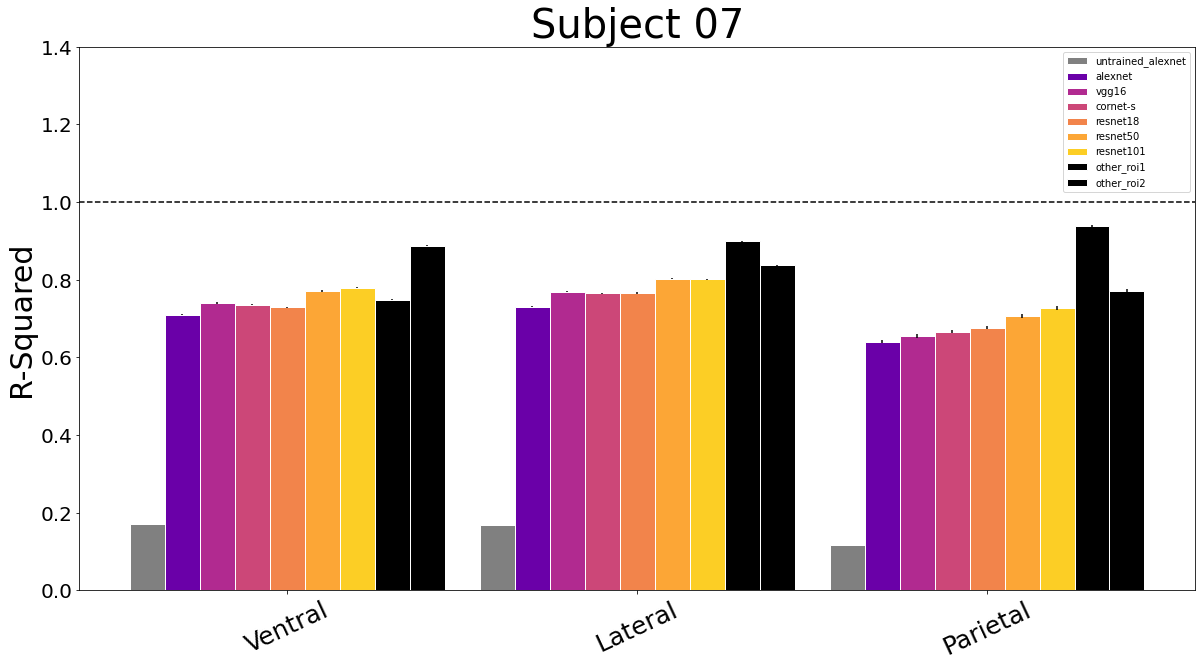

08


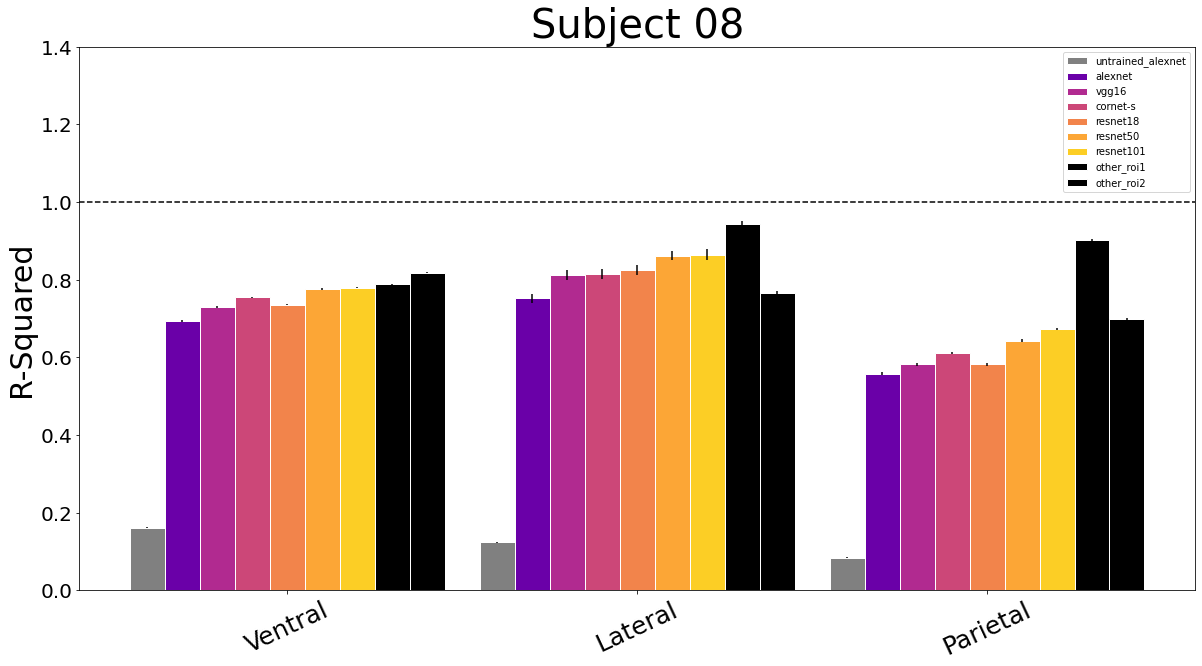

In [9]:
models = [ "untrained_alexnet", "alexnet_torch", "vgg16", "cornet-s", "resnet18","resnet50", "resnet101","other_roi1", "other_roi2"]
corrected_medians = np.empty((len(subjid), len(ROI_NAMES), len(models)))

cmap = matplotlib.cm.get_cmap('plasma')
rgba = np.zeros((len(models), 4))
color_range = [0, .2, .4, .5, .7, .8, .9, .99, .99]
for midx, model_name in enumerate(models):
    if model_name == "untrained_alexnet":
        rgba[midx,:] = [128/255, 128/255, 128/255, 1]
    elif model_name == "other_roi1" or model_name == "other_roi2":
        rgba[midx,:] = [0/255, 0/255, 0/255, 1]
    else:
        rgba[midx,:] = cmap(color_range[midx])
        
for sidx, sid in enumerate(subjid):
    print(sid)
    fig, ax = plt.subplots(figsize=(20, 10))
    fig.patch.set_facecolor('white')
    
    # set width of bars
    barWidth = 0.1
    
    for midx, model_name in enumerate(models):
        
        for r in range(len(ROI_NAMES)):
            corrected_medians[sidx][r][midx] = np.median(reject_outliers(all_rs[sidx][r][midx]/all_s2s_rs[sidx][r]))
                        
        data = [np.median(reject_outliers(all_rs[sidx][r][midx]/all_s2s_rs[sidx][r])) for r in range(len(ROI_NAMES))]
        error = [stats.sem(reject_outliers(all_rs[sidx][r][midx]/all_s2s_rs[sidx][r])) for r in range(len(ROI_NAMES))]

        # Set position of bar on X axis
        if midx == 0:
            base = np.arange(len(data))
            r = [x - (barWidth)*(len(models)/2) for x in base]
        else:
            r = [x + barWidth for x in prev_r]

        # Make the plot
        if model_name == "alexnet_torch":
            plt.bar(r, data, yerr=error, width=barWidth, edgecolor='white', color = rgba[midx], label="alexnet")
        else:
            plt.bar(r, data, yerr=error, width=barWidth, edgecolor='white', color = rgba[midx], label=model_name)
        
        prev_r = r
        
    plt.axhline(y = 1, xmin = 0, xmax = 1, color = 'black', linestyle='dashed')
    plt.xticks([r - barWidth/2 for r in range(len(data))], ROI_NAMES, rotation=25, fontsize=25);

    plt.ylabel('R-Squared',size = 30)
    plt.yticks(fontsize=20)
    
    plt.ylim([0, 1.4])

    title_string = "Subject "
    title_string += sid
    plt.title(title_string,size = 40)

    # Create legend & Show graphic
    plt.legend(fontsize=10)

    save_path = (RESULTS_PATH 
                + "fits/figures/subj"
                + sid
                + "_both_hemis_"
                + roi
                + "_cross_roi_included_norm_by_s2s_"
                + str(n_source_voxels)
                + "_source_voxels_HVA_only.png")

    #fig.savefig(save_path)
    plt.show()



In [10]:
#corrected_medians[corrected_medians < 0] = np.nan

In [11]:
d = {
    'subject_name': np.concatenate((np.tile('subj01',len(ROI_NAMES)*len(models)), 
                                    np.tile('subj02',len(ROI_NAMES)*len(models)), 
                                    np.tile('subj03',len(ROI_NAMES)*len(models)),
                                    np.tile('subj04',len(ROI_NAMES)*len(models)),
                                    np.tile('subj05',len(ROI_NAMES)*len(models)),
                                    np.tile('subj06',len(ROI_NAMES)*len(models)),
                                    np.tile('subj07',len(ROI_NAMES)*len(models)),
                                    np.tile('subj08',len(ROI_NAMES)*len(models)))),
    'roi': np.tile(ROI_NAMES, len(subjid)*len(models)),
    'Model': np.ravel(np.tile(np.ravel([np.tile(m, len(ROI_NAMES)) for m in models]), len(subjid))),
    'corrected': np.swapaxes(corrected_medians,1,2).ravel()
    
}

In [12]:
corrected_medians.shape

(8, 3, 9)

In [13]:
df = pd.DataFrame(d,columns=['subject_name','roi','Model', 'corrected'])
df 

,subject_name,roi,Model,corrected
0,subj01,Ventral,untrained_alexnet,0.227312
1,subj01,Lateral,untrained_alexnet,0.179868
2,subj01,Parietal,untrained_alexnet,0.177754
3,subj01,Ventral,alexnet_torch,0.830621
4,subj01,Lateral,alexnet_torch,0.735063
...,...,...,...,...
211,subj08,Lateral,other_roi1,0.942220
212,subj08,Parietal,other_roi1,0.902406
213,subj08,Ventral,other_roi2,0.818298
214,subj08,Lateral,other_roi2,0.766983


In [14]:
# Wanted palette details
roi_palette = ['#a6a6a6' , '#f4bdd8', '#ccdaff', '#b3ffc6',  '#DC267F' ,'#4d7fff','#006600']
color_codes_wanted = ROI_NAMES
#cdict = dict(zip(color_codes_wanted, [mcolors.to_rgba(c) for c in roi_palette]))
cdict = dict(zip(models, rgba))
#
mcolors.get_named_colors_mapping().update(cdict)
#
model_colors=np.ravel([np.tile(m, len(ROI_NAMES)) for m in models])

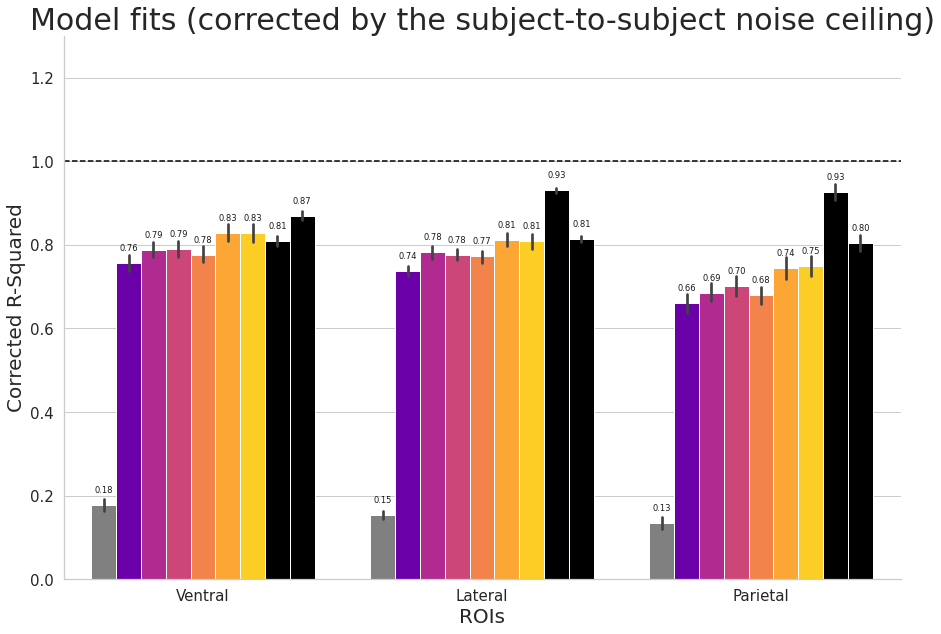

In [16]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y+.03, value, ha="center", fontsize='x-small', color='k') 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(x="roi", y="corrected", hue="Model",palette='cool_r',data=df, ci=68, ax=ax)
show_values_on_bars(ax)


for idx, bar in enumerate(ax.patches):
    bar.set_color(model_colors[idx])
    bar.set_edgecolor("w")
    
# iterate over range of number of rows    
ax.set_xlabel('ROIs', fontsize=20)
ax.set_ylabel('Corrected R-Squared', fontsize=20)
ax.tick_params(labelsize=15)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.legend([],[], frameon=False)
#h, l = ax.get_legend_handles_labels()
#model_labels = models
#ax.legend(h, model_labels)

plt.title('Model fits (corrected by the subject-to-subject noise ceiling)',size = 30)
plt.ylim([0, 1.3])

ax.axhline(y = 1, xmin = 0, xmax = 1, color = 'black', linestyle='dashed')

save_path = (RESULTS_PATH 
                + "fits/figures/groupavg_both_hemis_"
                + roi
                + "_cross_roi_included_norm_by_s2s_"
                + str(n_source_voxels)
                + "_source_voxels_HVA_only_Ridge.png")
#
fig.savefig(save_path)